In [1]:
import numpy as np
import thinkstats2
import thinkplot
import random
import math

# 08. 估计
本章代码位于`estimation.py`中。

## 8.1 估计游戏
假设有一个分布，我们来猜这个分布是什么。两个提示：这是一个正态分布；分布的随机样本如下：
```python
[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]
```

你猜这个分布的均值$\mu$是多少？

一个方法是使用样本均值$\bar x$作为$\mu$的估计。在本例中，$\bar x$为0.155，因此合理的猜测是$\mu = 0.155$。这个过程称为`估计`（estimation），我们使用的统计量（样本均值）称为`估计量`（estimator）。

使用样本均值估计$\mu$是显而易见的方法，我们似乎很难想出其他方法。现在假设引入离群值，例如小数点写错位置：
```python
[-0.441, 1.774, -0.101, -1.138, 2.975, -213.8]
```

现在你该如何估计$\mu$？如果使用样本均值，你的估计值会是`-35.12`。除了用样本均值进行估计还有其他方法吗？

一种方法是找出并去除离群值，然后计算剩余的样本均值。另一种方法是使用`中位数`作为估计量。

使用哪种估计量效果更好？这取决于具体情况（例如是否存在离群值）及目标。你要使误差最小，还是要使答案正确的几率最大？

如果没有离群值，那么使用样本均值作为估计量能够使`均方误差`（mean squared error，MSE）最小。也就是说，如果我们将这个估计游戏进行多次，计算每次的误差$\bar x - \mu$，那么样本均值可以使下面的值最小：

+ $\displaystyle \rm{MSE} = \frac{1}{m}\sum{(\bar x - \mu)^2}$

其中$m$为游戏次数，请不要把它和$n$搞混了，$n$是用于计算$\bar x$的样本大小。

下面的函数模拟估计游戏，计算均方误差的平方根，即`均方根误差`（root mean squared error，RMSE）：

In [2]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return math.sqrt(mse)

def Estimate1(n=7, m=1000):
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))

Estimate1()

rmse xbar 0.37697506539674636
rmse median 0.44771345115916694


`estimates`是估计列表，`acutal`是待估计的实际值。当然，在实际应用中我们无法知道`actual`。如果`actual`已知，那我们就无需进行估计了。这个实验的目的是比较这两个估计量的性能优劣。

运行上面的代码，我们得到样本均值的均方根误差为0.41。也就是说，如果我们基于$n=7$的样本，使用$\bar x$估计分布的均值，那么预期的偏差平均为0.41。使用中位数估计均值得到的均方根误差为0.53，证实使用$\bar x$的均方根误差较小，至少在本例中是如此。

使均方误差最小当然很好，但不一定是最佳策略。例如，假设我们要估计一个建筑工地的风速分布。如果估计的结果太高，那么我们可能会不必要地增加结构强度，导致成本增加；但如果估计的结果太低，建筑物可能会倒塌。估计值偏大或是偏小，导致的成本变化并不相同，因此一味追求均方误差最小并非最佳策略。

再举个例子，假设我掷3次骰子，让你预测点数总和。如果你猜对了，就会赢得奖品，猜错了则空手而归。在这种情况下，使均方误差最小的估计值是10.5，但是这个猜测显然不靠谱，因为掷3次骰子得到的总点数不可能是10.5。此时，你希望作出最可能与实际值相符的估计，即`最大似然估计量`（maximum likelihood estimator，MLE）。如果你猜10或者11，正确的可能性最大，为1/8。

## 8.2 猜测方差
假设一个正态分布，样本如下：

```python
[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]
````

你猜这个分布的方差${\sigma}^2$是多少？最显而易见的办法是用样本方差$S^2$作为估计量：

+ $\displaystyle S^2 = \frac{1}{n}\sum{(x_i - \bar x)^2}$

对于大样本，$S^2$是不错的估计量。但是对于小样本，$S^2$通常比方差分布低很多。由于这个糟糕的属性，人们将$S^2$称为`偏倚`（biased）估计量。如果对于多次重复实验，一个估计量的预期误差总和（或均值）为0，那么这个估计量就是`无偏`的（unbiased）。

幸好，还有一个简单统计量是$\sigma^2$的无偏估计量：

+ $\displaystyle S_{n-1}^2 = \frac{1}{n-1}\sum{(x_i - \bar x)^2}$

至于为什么$S_{n-1}^2$是无偏的，请参考[Wikipedia](http://wikipedia.org/wiki/Bias_of_an_estimator)。

这个估计量的最大问题是，名字和符号用法不一致：名字是`样本方差`，既可以指$S^2$，也可以指$S_{n-1}^2$，而二者都使用符号$S^2$。

下面的函数模拟了这个估计游戏，并测试$S^2$和$S_{n-1}^2$的性能。

In [3]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

def Estimate2(n=7, m=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.1424665371031224
mean error unbiased 0.0004557067130238615


再次提醒：$n$是样本大小，而$m$是游戏进行的次数。默认情况下，`np.var`计算$S^2$；如果指定参数$\rm{ddof}=1$，`ddof`代表`自由度增量`（delta degrees of freedom），`np.var`则计算$S_{n-1}^2$。我在这里不会解释自由度增量是什么，你可以参考[Wikipedia](http://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics))。

运行上面的代码，得到$S^2$的误差均值为-0.13。正如我们所料，这个偏倚估计量总是偏低。$S_{n-1}^2$的误差均值为0.014，约为$S^2$误差均值的1/10。随着$m$增加，我们预期$S_{n-1}^2$的误差均值会逐渐接近0。

均方误差和偏倚都属于长期属性，建立在估计游戏多次重复的基础上。通过运行如本章所示的模拟代码，我们可以比较估计量，检验其是否具有我们预期的属性。但是，如果将一个估计量用于真实数据，你只能进行一次估计。在这种情况下，说一个估计无偏没有任何意义。无偏是估计量的属性，而不是某次估计的属性。

选择具有适当属性的估计量，并用其生成一个估计后，下一步是描述这个估计的不确定性。这就是下一节讨论的内容。

## 8.3 抽样分布
假设你是一位科学家，在野生动物保护区研究大猩猩。你想知道保护区中成年雌性大猩猩的平均体重。要给猩猩称重，你必须将它们麻醉。这种做法既危险又有很高成本，还可能伤害大猩猩。但是，如果获得保护区中成年雌性大猩猩的平均体重非常重要，我们也许可以测量9只大猩猩的体重作为样本。假设我们对保护区中大猩猩的情况非常了解，那么就能选出具有代表性的成年雌性大猩猩样本。我们可以使用这个样本均值$\bar x$来估计未知的总体均值$\mu$。

测量了9只雌性大猩猩的体重后，你得到$\bar x = 90$千克，样本均方差$S = 7.5$千克。样本均值是总体均值$\mu$的无偏估计量，在多次重复实验中可以使均方误差最小。因此，如果需要用一个估计值来概括结果，你应该估计保护区中成年雌性大猩猩的平均体重为90千克。

但是，你对这个估计值的准确性有多少信心呢？如果只是从数量庞大的大猩猩总体中抽取9只测量体重，有可能运气不好，抽到了最重的9只。由随机选择导致的估计变化称为`抽样误差`（sampling error）。

为了量化抽样误差，我们可以假定$\mu$和$\sigma$的取值，模拟抽样过程，观察$\bar x$如何变化。

由于总体$\mu$和$\sigma$的实际值未知，因此我们将使用估计值$\bar x$和$S$。我们需要回答的问题是：如果 μ 和 σ 的实际值分别为90千克和7.5千克，在多次运行相同的实验后，估计均值$\bar x$将如何变化？

解答这个问题的代码如下：

No handles with labels found to put in legend.


standard error 2.4855299211339665
confidence interval (85.9378278650099, 94.16525611744194)


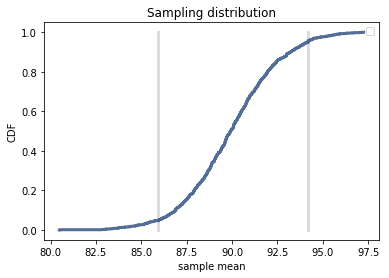

<Figure size 576x432 with 0 Axes>

In [4]:
def SimulateSample(mu=90, sigma=7.5, n=9, m=1000):
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    means = []
    for _ in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)

    stderr = RMSE(means, mu)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(means)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Show(root='estimation1', xlabel='sample mean', ylabel='CDF', title='Sampling distribution')

SimulateSample()

抽样分布的均值与假定值$\mu$非常接近，说明平均而言，这个实验产生了正确的结果。在1000次重复实验中，最低结果为82千克，最高结果为98千克。这个范围说明估计值与实际值的偏差可能达到8千克。

人们通常用两种方法对抽样分布进行概括：
+ **标准误差（standard error，SE）**    
    度量预期估计值平均偏离实际值多少。对每次模拟实验，先计算误差$\bar x - \mu$，然后计算均方根误差，即得到标准误差。在这个示例中，标准误差约为2.5千克

+ **置信区间（confidential interval，CI）**  
    包含抽样分布中指定比例的范围。例如，90%置信区间是从第5百分位数到第95百分位数。在这个示例中，90% CI是(86,94)千克

关于标准误差和置信区间的误解有很多：
+ 人们常常混淆标准误差和标准差。请记住：标准差描述的是度量值的变化。在这个示例中，大猩猩体重的标准差是7.5千克。标准误差描述的是估计值的变化。在这个示例中，基于9个测量样本估计出的均值标准误差为2.5千克
+ 标准误差和标准差有一个区别：随着样本量的增加，标准误差会变小，而标准差则不变。

人们常常认为，实际参数$\mu$落入90%置信区间的概率为90%。不幸的是，这种想法并不正确。如果你要得出类似的结论，就必须使用贝叶斯方法（请参考我写的`Think Bayes`一书）。

抽样分布回答的是另一个问题，告诉你重复进行实验时一个估计值会如何变化，使你对估计值的可靠性有所了解。

置信区间和标准误差只量化了抽样误差，即由于只测量了总体中的部分成员而导致的误差。记住这一点非常重要。抽样分布不考虑其他情况的误差，特别是`抽样偏倚`和`测量误差`。下一节将讨论抽样偏倚和测量误差。

## 8.4 抽样偏倚
假设你不需要测量自然保护区中大猩猩的体重，而是要了解所在城市女性的平均体重。此时你不太可能选取一个具有代表性的样本，并测量她们的体重。

一个简单的方法是`电话抽样`：你可以从电话簿中选取随机号码，致电要求与一位成年女性通话，并询问她的体重。

电话抽样具有明显的局限性。例如，样本限于公开了电话号码的居民，因而排除了没有电话的人（这些人可能比较穷）和未公布号码的人（这些人可能比较富有）。而且，如果你在白天拨打家庭电话，就不太可能访问到上班的人。如果你只对接电话的人进行访问，就不太可能访问到与别人共享一个号码的人。

如果收入、就业状况和家庭人口等因素与体重相关（确实可能），那么你的调查结果就会受到这样或那样的影响。这种问题是抽样过程的属性，因此称为`抽样偏倚`（sampling bias）。

另外，如果你只是询问别人的体重，而不进行测量，那么得到的结果可能是不准确的。即便调查参与者很愿意回答你的问题，但如果她们对自己的真实体重不满意，也有可能会对数字进行一些`美化`，更何况并不是所有的参与者都那么配合。这些都属于`测量误差`（measurement error）。

在汇报一个估计值时，你可以给出`标准误差`或`置信区间`，也可以都给出以量化`抽样误差`。但是，你要记住：`抽样误差`只是误差的来源之一，而且通常并不是最大的误差来源。

## 8.5 指数分布
再玩一次猜测游戏，这次是一个`指数分布`，样本如下：
```python
[5.384, 4.493, 19.198, 2.790, 6.122, 12.844]
```

你猜这个分布的参数$\lambda$是多少？通常，指数分布的均值是$\frac{1}{\lambda}$，那么倒推一下，我们应该选择：

+ $\displaystyle \rm{L} = \frac{1}{\bar x}$

$\rm{L}$是$\lambda$的一个估计量。这个估计量很特别，它还是[最大似然估计量](http://wikipedia.org/wiki/Exponential_distribution#Maximum_likelihood)。因此，如果你想最大化自己猜中$\lambda$的几率，就应该选择$\rm{L}$。

但是，我们知道当存在离群值时，$\bar x$的健壮性不佳，因此预期$\rm{L}$也具有同样的问题。

我们可以选择基于样本中位数的估计量。指数分布的中位数是$\displaystyle \frac{\ln 2}{\lambda}$，倒推一下，我们可以定义一个估计量：

+ $\displaystyle \rm{L_m} = \frac{\ln{2}}{m}$

其中$m$是样本的中位数。

为了测试这两个估计量的性能，我们可以对抽样过程进行模拟：

In [5]:
def Estimate3(n=7, m=1000):
    lam = 2

    means = []
    medians = []
    for _ in range(m):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = math.log(2) / thinkstats2.Median(xs)
        means.append(L)
        medians.append(Lm)

    print('rmse L', RMSE(means, lam))
    print('rmse Lm', RMSE(medians, lam))
    print('mean error L', MeanError(means, lam))
    print('mean error Lm', MeanError(medians, lam))

Estimate3()

rmse L 1.0510076088419902
rmse Lm 2.413678385738004
mean error L 0.3303078465770361
mean error Lm 0.4764853551576278


以$\lambda = 2$运行这个实验，得到的$\rm{L}$的均方根误差为1.1。对于基于中位数的估计量$\rm L_m$，均方根误差为1.8。从这个实验中，我们无法得知$\rm L$是否使均方误差最小，但是至少看起来$\rm L$比$\rm L_m$更接近真实值。

不幸的是，这两个估计量似乎都是偏倚的。$\rm L$的均值误差为0.33，$\rm L_m$的均值误差为0.45，而且随着样本量$m$的增加，二者的均值误差都不会趋近于0。

实际上，$\bar x$是指数分布均值$\frac{1}{\lambda}$的无偏估计量，而$\rm L$却不是$\lambda$的无偏估计量。